In [1]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    max_samples=0.8,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)


## 1. Setup

In [2]:
# 1. Bibliotecas básicas
import os
import pandas as pd
import numpy as np
import ast
import pickle            # para salvar o modelo
from datetime import datetime

# 2. Sklearn — split, pré-processamento, modelo e métricas
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 3. Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# 4. Semente para reprodutibilidade
SEED = 42


## 2. Carregando CSV

In [3]:
# ajuste o caminho conforme seu projeto
DATA_PATH = "dados/df_consolidado.csv"  
df = pd.read_csv(DATA_PATH, low_memory=False)

# descartar linhas incompletas
col_essenciais = [
    "id_votacao","id_deputado","tipoVoto","siglaUf","id_partido",
    "id_proposicao","data","sigla_orgao","aprovacao","cod_tipo",
    "numero_proposicao","ano","orientacao","id_autor","tema"
]
df.dropna(subset=col_essenciais, inplace=True)

# converter votos para binário
df["tipoVoto"] = df["tipoVoto"].map({"Sim":1, "Não":0}).fillna(0).astype(int)


## 3. Definição de X e y

In [4]:
# alvo: se a proposição foi aprovada (1) ou não (0)
y = df["aprovacao"].astype(int)

# features brutas
X = df[["siglaUf","id_partido","cod_tipo","ano","tema"]].copy()

# extrair só o primeiro tema
def extrai_tema(x):
    try:
        lst = ast.literal_eval(x)
        return lst[0] if lst else "Outros"
    except:
        return "Outros"

X["tema_principal"] = X["tema"].apply(extrai_tema)
X.drop(columns="tema", inplace=True)


## 4. Pré Processamento

In [5]:
categorical_features = ["siglaUf", "tema_principal"]
numeric_features     = ["id_partido", "cod_tipo", "ano"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(),       numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
])


## 5. Split treino / teste

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=SEED
)
print("Treino:", X_train.shape, "Teste:", X_test.shape)


Treino: (704761, 5) Teste: (176191, 5)


## 6. Cross-validation rápida (5 folds)

In [7]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    class_weight="balanced",
    n_jobs=-1,
    random_state=SEED
)

pipe = Pipeline([
    ("preproc", preprocessor),
    ("rf",      model)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1_macro", n_jobs=-1)
print("F1-macro CV por fold:", np.round(scores,4))
print("→ Média:", scores.mean().round(4), "| Desvio:", scores.std().round(4))


F1-macro CV por fold: [0.7433 0.7412 0.7431 0.7407 0.7408]
→ Média: 0.7418 | Desvio: 0.0012


## 7. Treino final e avaliação no hold-out

              precision    recall  f1-score   support

           0       0.81      0.84      0.82    113452
           1       0.69      0.64      0.66     62739

    accuracy                           0.77    176191
   macro avg       0.75      0.74      0.74    176191
weighted avg       0.76      0.77      0.77    176191



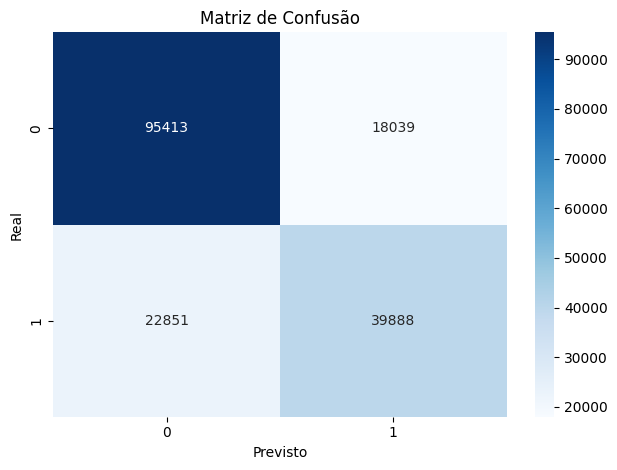

In [8]:
# ajusta no treino completo
pipe.fit(X_train, y_train)

# previsão e relatório
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

# matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


## 8. Salvando o modelo em .pkl

In [9]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
out_path = f"modelo_random_forest_{timestamp}.pkl"

with open(out_path, "wb") as f:
    pickle.dump(pipe, f)

print("Modelo salvo em:", out_path)


Modelo salvo em: modelo_random_forest_20250630_1632.pkl
